 Honours Project - MHW225671  
 Name: Giacomo Fadda  
 Student ID: S2219926  
 Programme of Study: BSc Computing

In [1]:
import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

In [2]:
# check if the system recognise the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
dataset_directory = os.listdir('D:/Honours Project/Dataset/Plant_leave_diseases_dataset/')
for filenames in dataset_directory:
    print(filenames)

Background_without_leaves
Apple___Cedar_apple_rust
Apple___Apple_scab
Apple___Black_rot
Apple___healthy
Grape___Black_rot
Grape___Esca_(Black_Measles)
Grape___healthy
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)


In [4]:
# Chech the datasete path
dataset_directory = pathlib.Path('D:/Honours Project/Dataset/Plant_leave_diseases_dataset/')
print(dataset_directory)

D:\Honours Project\Dataset\Plant_leave_diseases_dataset


#### Data Preprocessing

In [5]:
# Standardise the images in the dataset
Image_Size = 224
Batch_Size = 64
Channels = 3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory, 
    batch_size = Batch_Size, 
    image_size = (Image_Size, Image_Size), 
    shuffle = True,
    label_mode = 'categorical'
    ) 

Found 16867 files belonging to 9 classes.


In [6]:
#Folders(classes) in 'Dataset' directory
class_names = dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy']

In [7]:
print(len(dataset))

# print dataset info
print(dataset)

264
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>


In [8]:
# dividing the dataset into training, validation, and testing

def split_dataset(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    if train_split + val_split + test_split != 1:
        raise ValueError("The sum of train_split, val_split, and test_split must be 1.")
    
    ds_size = tf.data.experimental.cardinality(dataset).numpy()
    if ds_size == -1:
        raise ValueError("Dataset size is unknown. Make sure ds is a finite dataset.")


    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=123)
   
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)  # Correctly skips to take the remainder of the dataset for the test set
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [10]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), 
                                                                                                                                                        len(train_ds), 
                                                                                                                                                        len(val_ds), 
                                                                                                                                                        len(test_ds)))

Size of Data is :264 
Batch size of Training Data is :211
Batch size of Validation Data is :26 
Batch size of Testing Data is :27 


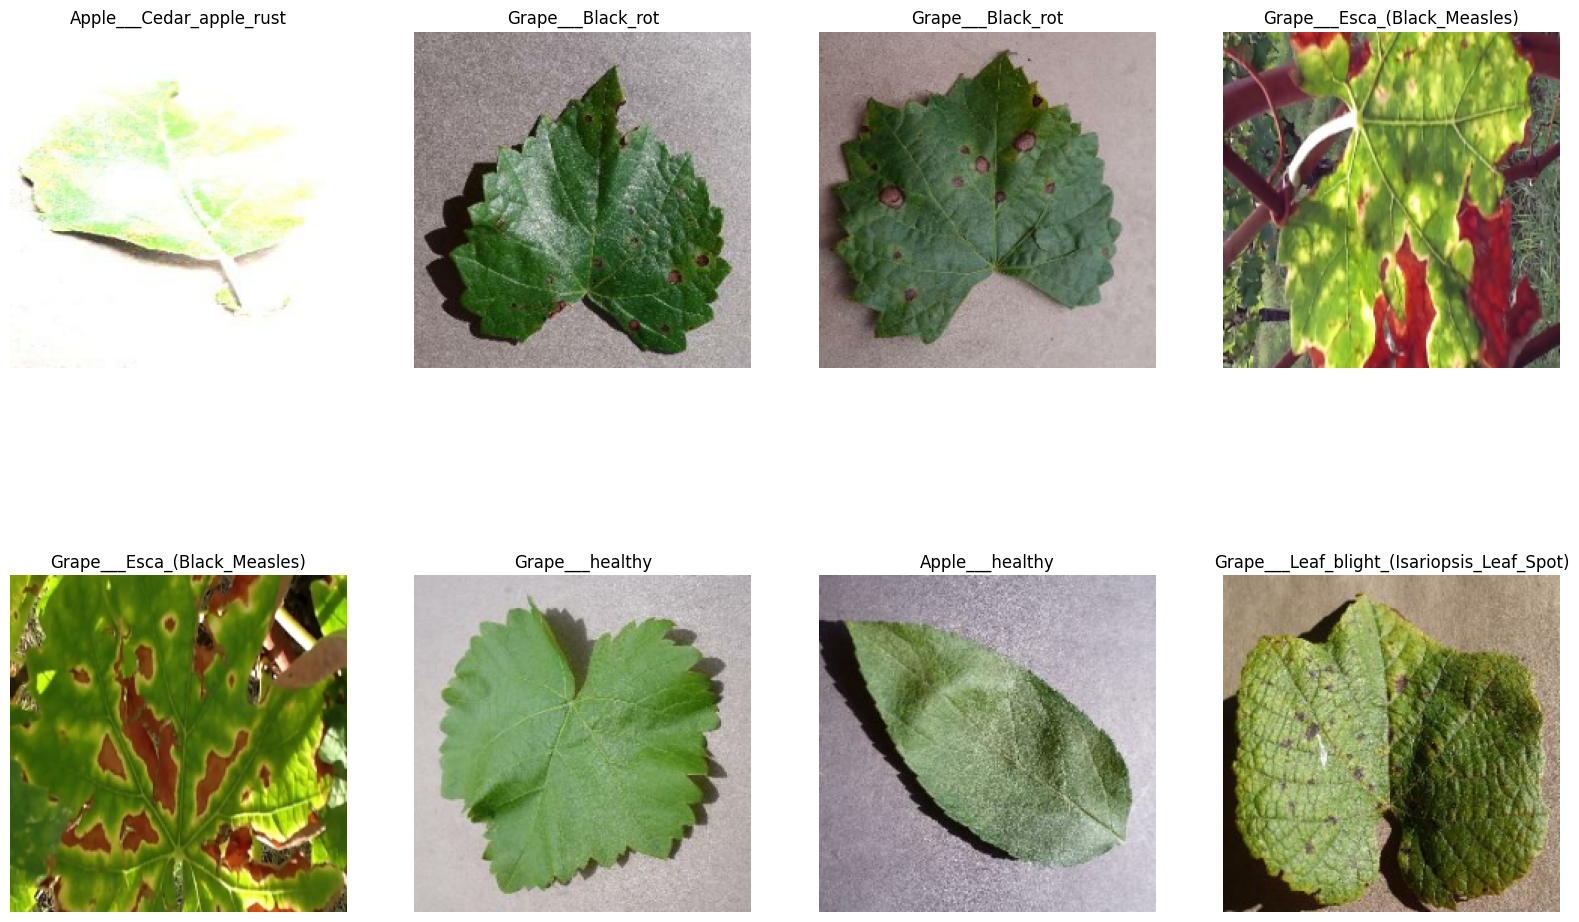

In [11]:

def show_batch(dataset, size=10):
    """Displays a batch of images and their labels from the dataset."""
    dataset_batch = dataset.unbatch().batch(size)
    images, labels = next(iter(dataset_batch))
    
    plt.figure(figsize=(20, 20))
    for i in range(size):
        ax = plt.subplot(3, 4, i + 1)  # Adjust grid size depending on the number of images
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

# Display 10 random images and labels from train_ds
show_batch(train_ds, 8)

In [12]:
# Processing the data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Model Structuring and training

In [13]:
num_classes = len(class_names)  

# Load EfficientNetB0 as a base model, with pretrained weights and without the top classification layer
base_model = EfficientNetB0(
    # because the model is insteaded for transfer learning the top layers are removed.
    # This option excludes the final Dense layer that turns 1280 features on the penultimate layer 
    # into prediction of the 1000 ImageNet classes. 
    # Replacing the top layer with custom layers allows using EfficientNet as a feature extractor
    # in a transfer learning workflow
    include_top=False, 
    weights="imagenet", 
    input_shape=(224, 224, 3)
)

# Freeze the base model layers to prevent them from being updated during the first phase of training.
# It is crucial to avoid losing the pre-trained features
base_model.trainable = False

# Define the top laye
top_layers = [
    # first convolutional layer with 32 small-size 3*3 filters
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # Normalizes the activations of the previous layer at each batch
    layers.BatchNormalization(),
    # First max-pooling layer eith 2*2 filter. 
    # It reduces the spatial dimensions (height and width) of the input volume for the next layer.
    layers.MaxPool2D((2, 2)),

    # Second convolutional layer with 64 small-size 3*3 filters 
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    # Second max-pooling layer eith 2*2 filter
    layers.MaxPool2D((2, 2)),

    # third convolutional layer with 128 small-size 3*3 filters
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    # The resulting filter maps are then flattened to provide features to the downstream classifier backend
    # Converts the 2D matrix data to a vector so it can be used in the dense layers
    layers.Flatten(),

    # For the classifier backend, we just use one hidden layer with 64 nodes
    # The hidden layer here is the regular fully-connected dense layer, with ReLU as the activation function.
    layers.Dense(64, activation='relu'),

    # Helps prevent overfitting by randomly setting a fraction of input units 
    # to 0 at each update during training time.
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
]

# Create the model using the Sequential API
# compound by Load EfficientNetB0 as a base model with pretrained weights and without the top classification layer
# and customised top_layers
model = models.Sequential([base_model] + top_layers)

# Set hyperparameters
learning_rate = 0.001
epochs = 50

# Compile the model with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Train the model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Suitable for one-hot encoded labels
    metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          368672    
                                                                 
 batch_normalization (Batch  (None, 7, 7, 32)          128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          18496     
                                                        

In [15]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    min_delta=1e-3,
    verbose=1,
)

# Train the model with early stopping
history = model.fit(
    train_ds, 
    validation_data = val_ds, 
    validation_steps = None, # relevant if validation_data is provided
    epochs = epochs, 
    callbacks = [early_stopping],  
)

Epoch 1/50


211/211 [==============================] - 226s 985ms/step - loss: 0.2720 - accuracy: 0.9154 - val_loss: 0.0697 - val_accuracy: 0.9844
Epoch 2/50
211/211 [==============================] - 190s 901ms/step - loss: 0.0497 - accuracy: 0.9833 - val_loss: 0.0332 - val_accuracy: 0.9874
Epoch 3/50
211/211 [==============================] - 203s 963ms/step - loss: 0.0355 - accuracy: 0.9893 - val_loss: 0.0172 - val_accuracy: 0.9952
Epoch 4/50
211/211 [==============================] - 200s 949ms/step - loss: 0.0248 - accuracy: 0.9922 - val_loss: 0.0142 - val_accuracy: 0.9964
Epoch 5/50
211/211 [==============================] - 196s 928ms/step - loss: 0.0164 - accuracy: 0.9953 - val_loss: 0.0135 - val_accuracy: 0.9964
Epoch 6/50
211/211 [==============================] - 208s 987ms/step - loss: 0.0108 - accuracy: 0.9969 - val_loss: 0.0404 - val_accuracy: 0.9910
Epoch 7/50
211/211 [==============================] - 191s 905ms/step - loss: 0.0201 - accuracy: 0.9930 - val_loss: 0.0323

In [16]:
# Evaluate the model's accuracy
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)

27/27 [==============================] - 35s 816ms/step - loss: 0.0103 - accuracy: 0.9971
Test accuracy: 0.9971064925193787


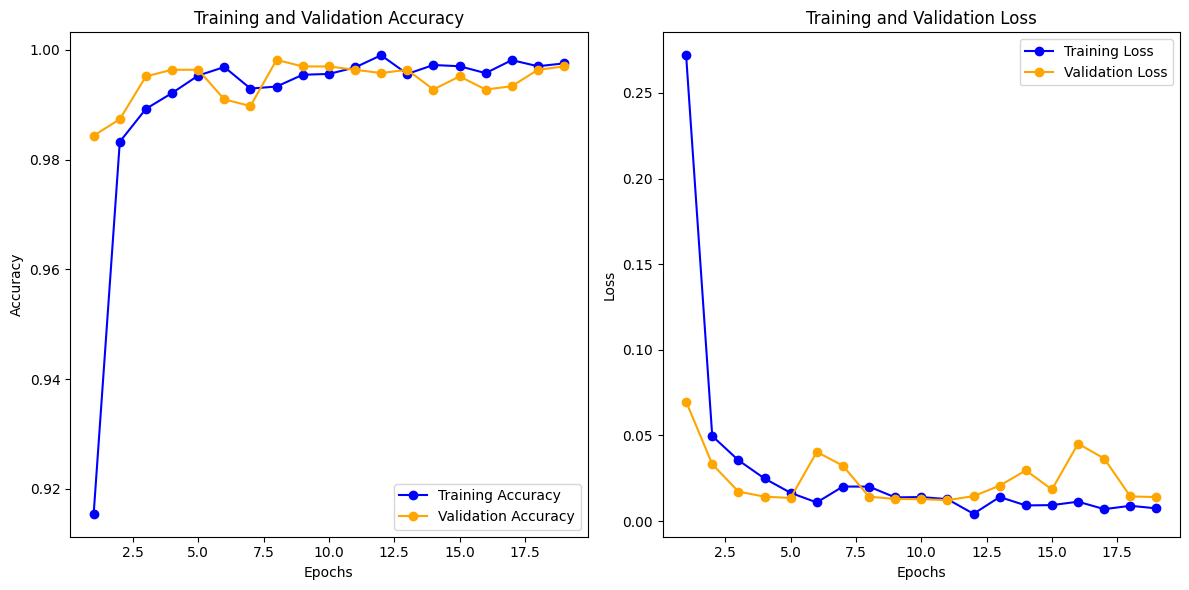

In [17]:
# Extracting metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Determine the number of epochs
epochs = len(acc)
epochs_range = range(1, epochs + 1)  # Create a range for the number of epochs

# Plotting
plt.figure(figsize=(12, 6))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

2/2 [==============================] - 1s 434ms/step

                                             precision    recall  f1-score   support

                        Apple___Apple_scab       1.00      0.99      1.00       198
                         Apple___Black_rot       0.99      1.00      0.99       199
                  Apple___Cedar_apple_rust       1.00      0.99      1.00       212
                           Apple___healthy       1.00      1.00      1.00       225
                 Background_without_leaves       1.00      1.00      1.00       122
                         Grape___Black_rot       1.00      0.99      0.99       200
              Grape___Esca_(Black_Measles)       0.99      1.00      1.00       210
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       1.00      1.00      1.00       155
                           Grape___healthy       1.00      1.00      1.00       207

                                  accuracy                           1.00      1728
                   

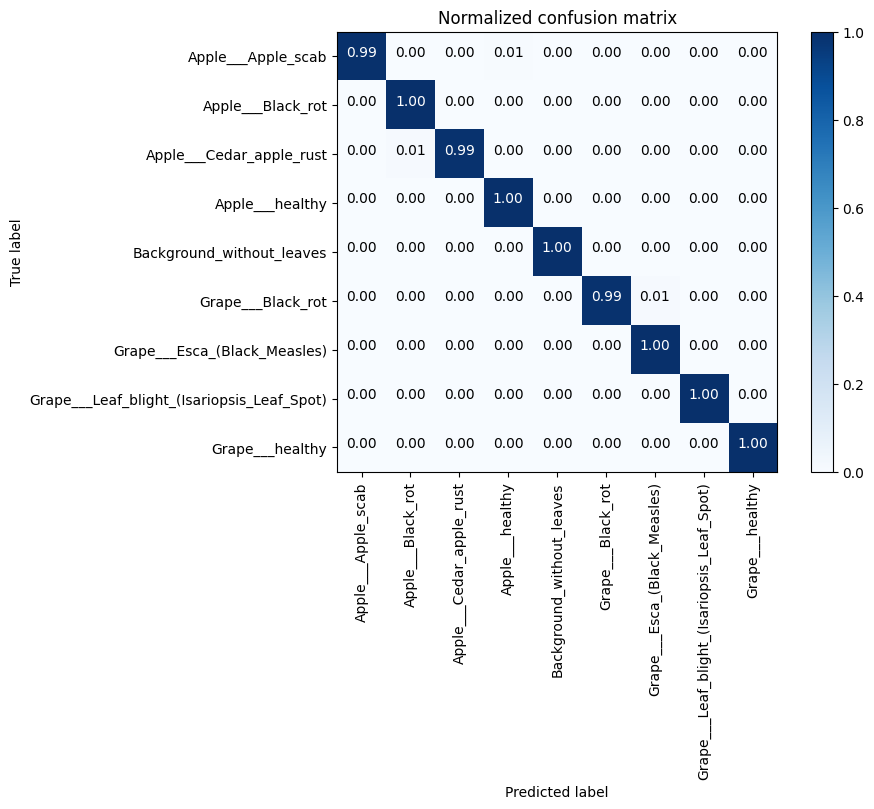

In [18]:
"""
Classification report
Make predictions on the test dataset 
builds a text report showing the main classification metrics
    
"""

y_pred = []
y_true = []
for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    true = np.argmax(labels.numpy(), axis=1)
    y_pred.extend(preds)
    y_true.extend(true)

# Compute precision, recall, and f1-score
print('\n', classification_report(y_true, y_pred, target_names=class_names))
    

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()


#### Second train fine-tuning

In [19]:
def unfreeze_model(base_model):
    #unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in base_model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):            
            layer.trainable = True

# Compile the model with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  
              metrics=['accuracy'])


# Train the model with fine-tuning
fine_history = model.fit(
    train_ds, 
    validation_data= val_ds, 
    epochs=epochs,  
    callbacks=[early_stopping],
    validation_steps = None
)


Epoch 1/19
211/211 [==============================] - 226s 1s/step - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.0055 - val_accuracy: 0.9988
Epoch 2/19
211/211 [==============================] - 206s 977ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0057 - val_accuracy: 0.9988
Epoch 3/19
211/211 [==============================] - 219s 1s/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0072 - val_accuracy: 0.9988
Epoch 4/19
211/211 [==============================] - 215s 1s/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0092 - val_accuracy: 0.9982
Epoch 5/19
211/211 [==============================] - 212s 1s/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0065 - val_accuracy: 0.9982
Epoch 6/19
211/211 [==============================] - 214s 1s/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0071 - val_accuracy: 0.9982
Epoch 7/19
211/211 [==============================] - 203s 960ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0062 - val_accuracy: 

In [20]:
# Evaluate the model's accuracy
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)

27/27 [==============================] - 23s 865ms/step - loss: 0.0030 - accuracy: 0.9994
Test accuracy: 0.9994212985038757


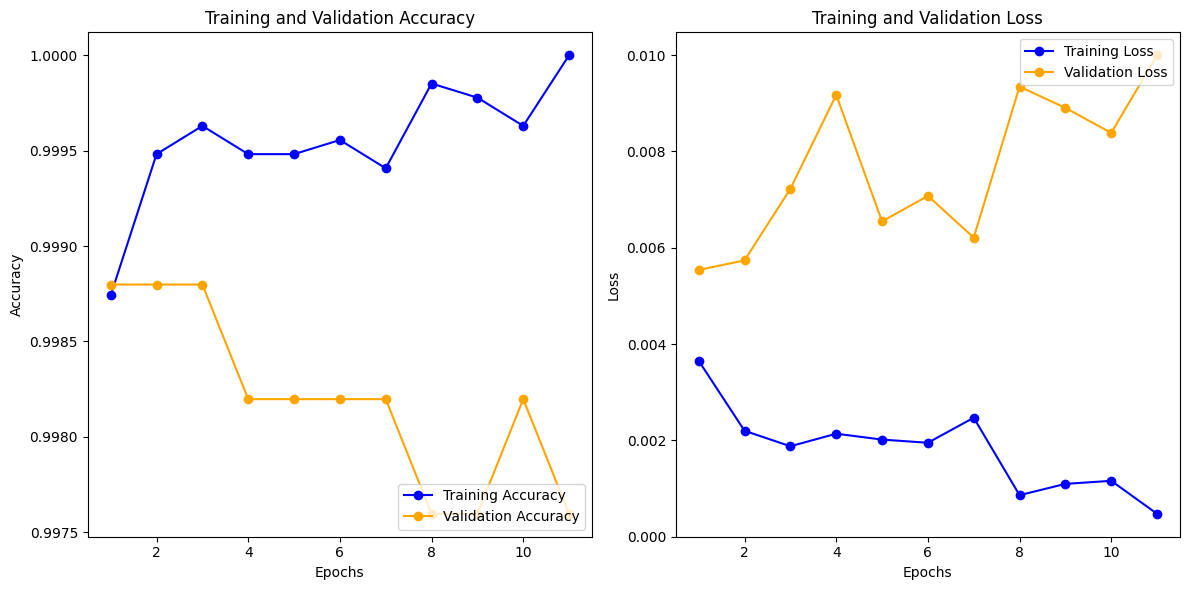

In [21]:
# Extracting metrics
acc = fine_history.history['accuracy']
val_acc = fine_history.history['val_accuracy']
loss = fine_history.history['loss']
val_loss = fine_history.history['val_loss']

# Determine the number of epochs
epochs = len(acc)
epochs_range = range(1, epochs + 1)  # Create a range for the number of epochs

# Plotting
plt.figure(figsize=(12, 6))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

2/2 [==============================] - 1s 511ms/step

                                             precision    recall  f1-score   support

                        Apple___Apple_scab       1.00      0.99      1.00       198
                         Apple___Black_rot       1.00      1.00      1.00       199
                  Apple___Cedar_apple_rust       1.00      1.00      1.00       212
                           Apple___healthy       1.00      1.00      1.00       225
                 Background_without_leaves       1.00      1.00      1.00       122
                         Grape___Black_rot       1.00      1.00      1.00       200
              Grape___Esca_(Black_Measles)       1.00      1.00      1.00       210
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       1.00      1.00      1.00       155
                           Grape___healthy       1.00      1.00      1.00       207

                                  accuracy                           1.00      1728
                   

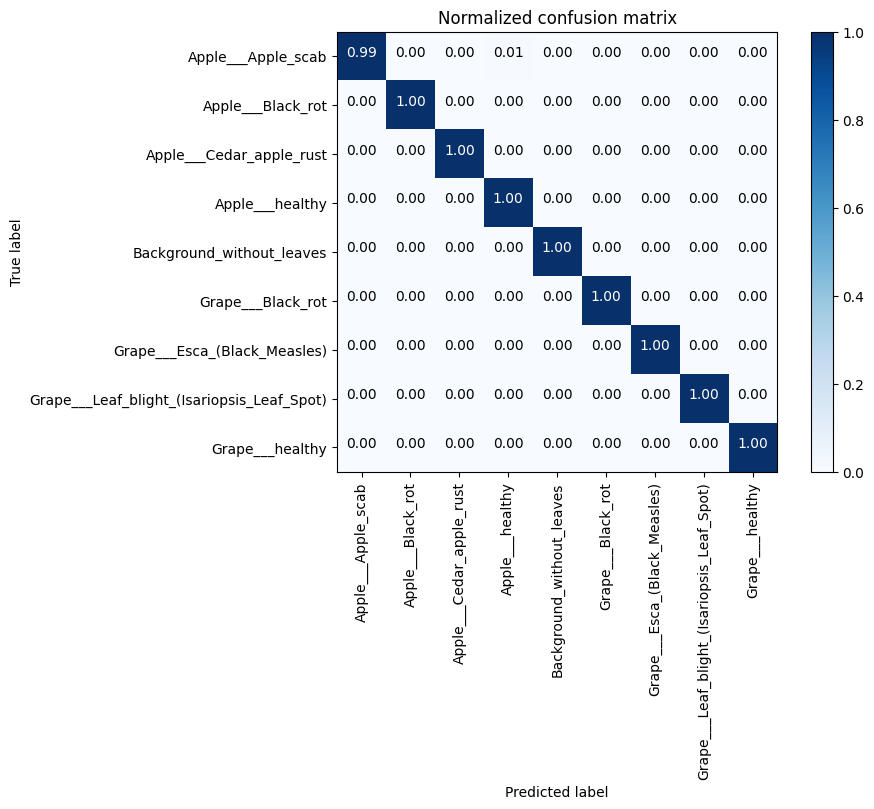

In [22]:
"""
Classification report
Make predictions on the test dataset 
builds a text report showing the main classification metrics
    
"""

y_pred = []
y_true = []
for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    true = np.argmax(labels.numpy(), axis=1)
    y_pred.extend(preds)
    y_true.extend(true)

# Compute precision, recall, and f1-score
print('\n', classification_report(y_true, y_pred, target_names=class_names))
    

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()

2/2 [==============================] - 1s 431ms/step


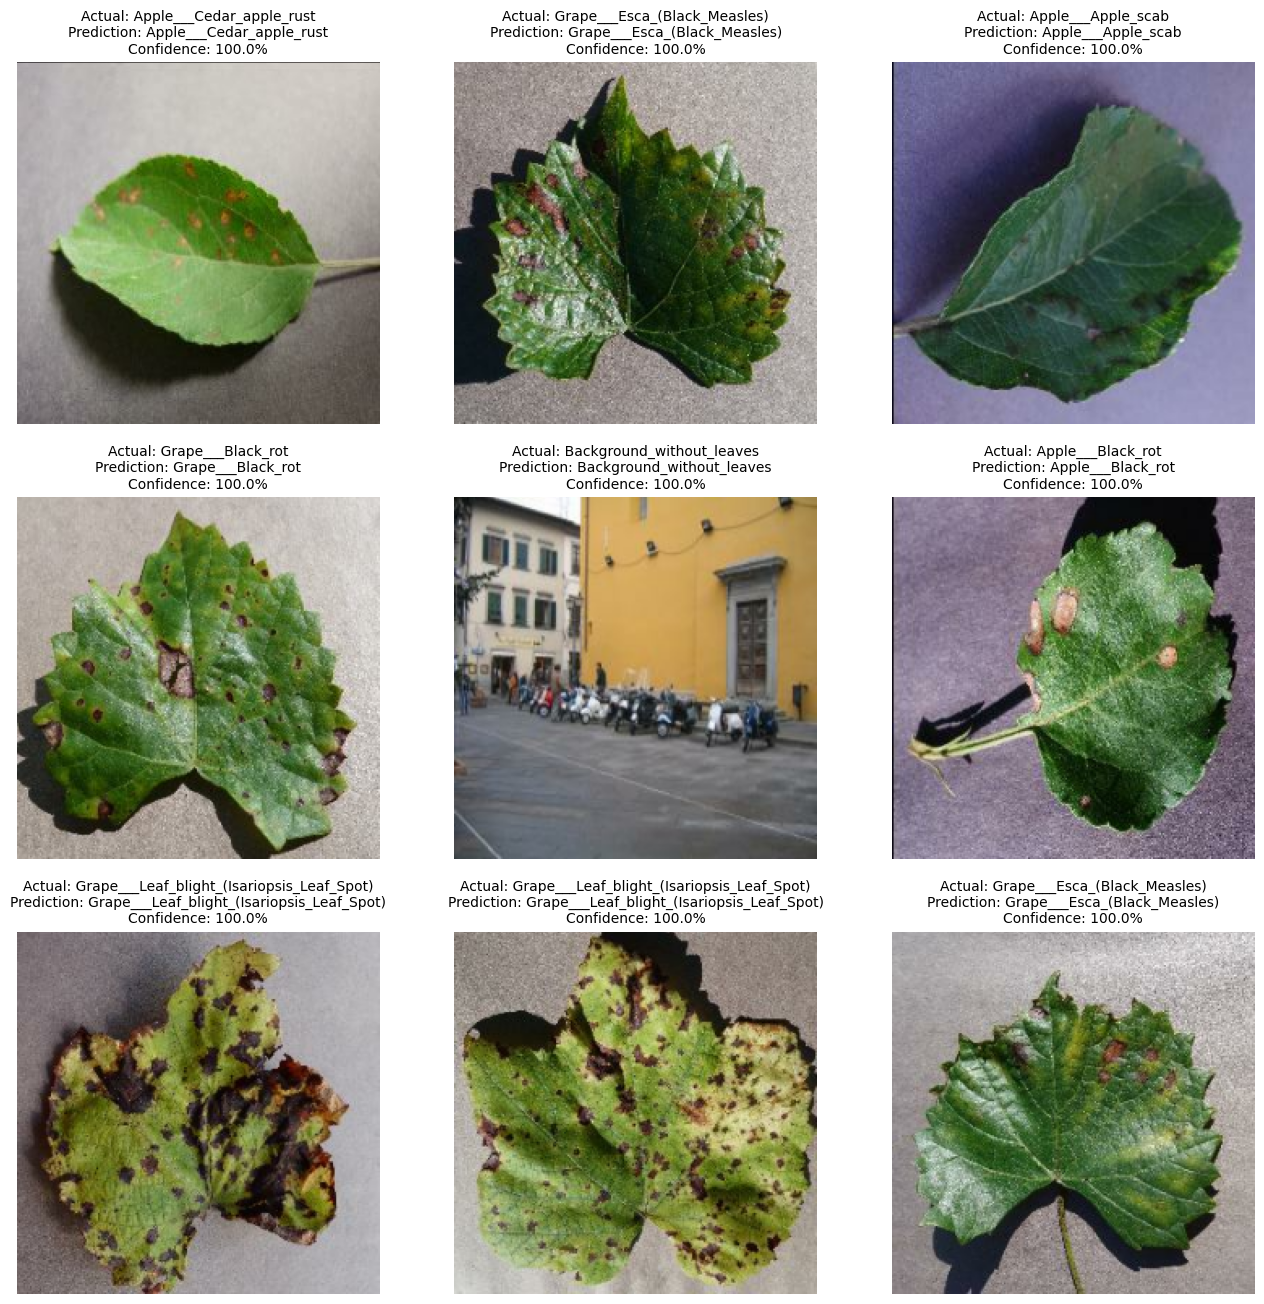

In [23]:
plt.figure(figsize=(16,16))
for batch_image, batch_label in test_ds.take(1):
    batch_prediction = model.predict(batch_image)  # Predict once per batch
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        plt.imshow(image)
        
        # Handling different label structures
        if len(batch_label[i].shape) == 0:  # Scalar label
            label_index = int(batch_label[i].numpy())
        elif len(batch_label[i].shape) == 1:  # One-hot encoded label or length-1 array
            label_index = np.argmax(batch_label[i].numpy())  # Use argmax for one-hot encoded labels
        else:
            raise ValueError("Unexpected label shape; check your dataset.")
        
        label = class_names[label_index]
        predicted_class = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        # Now with actual, prediction, and confidence on separate lines
        title_text = f'Actual: {label}\nPrediction: {predicted_class}\nConfidence: {confidence}%'
        plt.title(title_text, fontsize=10)  # Adjust fontsize as needed
        plt.axis('off')  # Optional: for a cleaner look
plt.show()

1/1 [==============================] - 0s 54ms/step


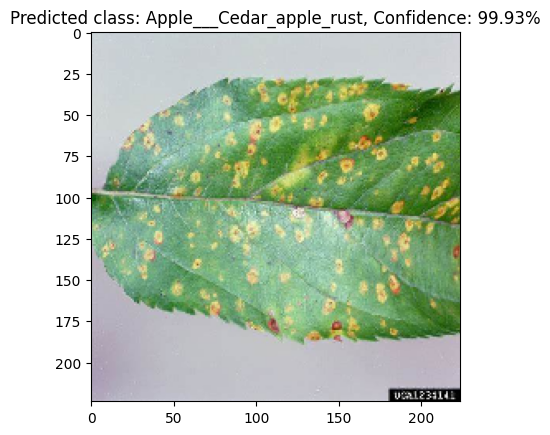

In [34]:
from tensorflow.keras.preprocessing import image
image_size = (224, 224)  # Adjust size as needed, without channel info for load_img

# Load and preprocess the image
img_path = "D:/Honours Project/test/apple_cedar_rust (3).jpeg"
img = image.load_img(img_path, target_size=image_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Make predictions using the model
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
confidence = 100 * np.max(predictions[0])  # Directly use the max value from predictions

# Display the image and prediction
plt.imshow(img)
plt.title(f"Predicted class: {class_names[predicted_class_index]}, Confidence: {confidence:.2f}%")
plt.show()

In [35]:
model.save("D:/Honours Project/pretrained_models/EfficientNetB0.keras")